In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [21]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

iris = load_iris()
X = iris.data
y = iris.target

# Standardize the features
scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [306]:
def train(model, epoch, optimizer):
    criterion = nn.CrossEntropyLoss()
    runs = []
    for epoch in range(epoch):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs[:,:3])
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        runs.append(running_loss/len(train_loader))
        # print(runs[-1])
    return runs

def eval(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs[:,:3])
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    # print(f'Accuracy of the model on the test data: {accuracy:.2f}%')
    return accuracy

def test(model, optimizer, epochs, runs):
    losses = []
    evals = []
    initial = model
    for i in range(runs):
        t = train(model, epochs, optimizer)
        losses.append(t)
        e = eval(model)
        evals.append(e)
        model = initial
    return losses, sum(evals)/runs

In [307]:
epochs = 20
learning_rate = 0.05
total_runs = 30

In [308]:
def test_optimizer(optimizer, learning_rate):
    simple_net = nn.Sequential(
        nn.Linear(3, 3),
        nn.ReLU(),
        nn.Linear(3, 3)
    ).to("cpu")
    opt = optimizer(simple_net.parameters(), lr=learning_rate)
    return test(simple_net, opt, epochs, total_runs)

In [302]:
import torch

class SnellOptimizer:
    def __init__(self, params, lr=0.01):
        self.params = list(params)
        self.learning_rate = lr
        self.prev = None
        # self.sim = torch.nn.CosineSimilarity(dim=0)
        self.eps = 1e-8

    def step(self):
        with torch.no_grad():
            _tmp = self.params
            for i, param in enumerate(self.params):
                if param.grad is not None:
                    grad = param.grad
                    nvectors = param.grad.size(0)
                    if self.prev is not None and len(grad.shape)==2:
                        vs = []
                        for j in range(nvectors):
                            new_v = self.snell(grad[j], self.prev[i].grad[j])
                            vs.append(new_v)
                        new_dir = torch.stack(vs)
                        if new_dir.isnan().any():
                            print(grad)
                            print(self.prev[i], new_dir)
                            raise
                        param -= self.learning_rate * new_dir
                    else:
                        # If is there any previous record, just step 
                        param -= self.learning_rate * param.grad
                    
                    self.prev = _tmp

    def snell(self, cur:torch.Tensor, prev:torch.Tensor):
        with torch.no_grad():
            if (1-cur).any(): return cur
            norm_cur, norm_prev = torch.norm(cur), torch.norm(prev)
            cos = torch.dot(cur, prev) / (norm_cur * norm_prev + self.eps)
            sin1 = torch.sqrt(1-cos**2).clip(0, 1)
            cross = torch.cross(cur, prev)
            vel_cur, vel_prev = torch.exp(-norm_cur), torch.exp(-norm_prev)

            u_cur = cur / norm_cur
            u_cross = cross / torch.norm(cross)
            u_ortho = torch.cross(u_cur, u_cross)
            # new basis for x, y, z coord
            basis = torch.stack([u_cur, u_ortho, u_cross])

            # snell's law
            sin2 = sin1 / (vel_prev+self.eps) * vel_cur
            # prevent reflecting all
            sin2 = sin2.clip(0, 1)
            cos2 = torch.sqrt(1-sin2**2).clip(0, 1)

            new_dir = torch.tensor([cos2, sin2, 0])
            # if new_dir.isnan().any() or norm_cur.isnan().any() or basis.isnan().any():
            #     print(norm_cur, norm_prev)
            #     print(cur, cross, u_ortho)
            #     print("basis", basis)
            #     print("cos", cos)
            #     print(sin1)
            return basis @ new_dir * norm_cur

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


In [312]:
optimizers = {
    "SGD": optim.SGD,
    "Adam": optim.Adam,
    "Snell": SnellOptimizer
}

learning_rates = {
    "SGD": learning_rate,
    "Adam": learning_rate,
    "Snell": 0.05
}

results = {}

for (name, opt) in optimizers.items():
    results[name] = test_optimizer(opt, learning_rate=learning_rates[name])

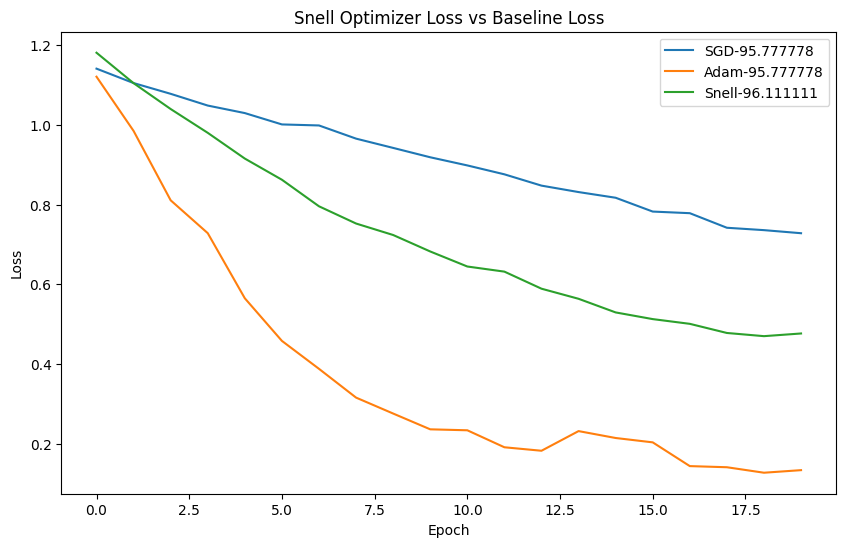

In [321]:
plt.figure(figsize=(10, 6))
for (name, (losses, acc)) in results.items():
    plt.plot(range(epochs), losses[0], label=f"{name}-{acc:2f}")
    # plt.plot(range(epochs), exp_track, label="Snell's law")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Snell Optimizer Loss vs Baseline Loss')
plt.legend()
plt.savefig("final.png", dpi=1000)
plt.show()